# Feeder ID Guide

Feeder IDs connect each substation to the branches and nodes it serves. The `Grid.set_feeder_ids()` call populates the `feeder_branch_id` and `feeder_node_id` columns on every branch array plus `grid.node`, so it is the starting point for structure-aware processing that relies on the active graph.

## What Feeder IDs Mean

- `feeder_branch_id` references the branch that leaves a substation (a node with `node_type==NodeType.SUBSTATION_NODE`) and feeds the component; every downstream branch that remains connected inherits the same feeder branch ID.
- `feeder_node_id` is the substation node ID that ultimately supplies the component. Nodes and branches without a feeding substation (including the substations themselves) receive an empty id `-2147483648`.

`Grid.set_feeder_ids()` resets any previous feeder columns, tags each branch touching a substation with `is_feeder`, temporarily removes all substations to find active components, and stamps every member of those components with the appropriate feeder IDs.

In [ ]:
from power_grid_model_ds import Grid

grid = Grid.from_txt(
    "S101 102 201",
    "102 103 202",
    "S101 104 203",
    "104 105 204",
    "103 105 205,open",
)

grid.set_feeder_ids()

The created grid has the following structure

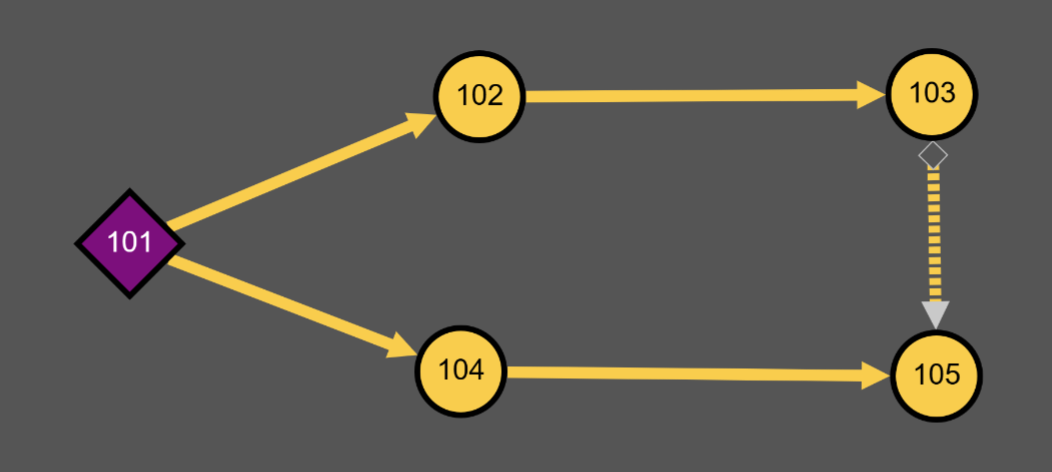

In [ ]:
print("Nodes")
for node in grid.node:
    node_id = node.id
    feeder_node = node.feeder_node_id
    feeder_branch = node.feeder_branch_id
    print(f"node {node_id}: feeder_node_id={feeder_node}, feeder_branch_id={feeder_branch}")
print()
print("Lines")
for line in grid.line:
    bid = line.id
    is_feeder = line.is_feeder
    from_node = line.from_node
    to_node = line.to_node
    feeder_branch = line.feeder_branch_id
    feeder_node = line.feeder_node_id
    print(
        f"line {bid}: is_feeder={is_feeder}, from_node={from_node}, to_node={to_node}, "
        f"feeder_branch_id={feeder_branch}, feeder_node_id={feeder_node}"
    )

## Inspecting the Results

After the calculation every branch and node that remains connected to substation 101 carries `feeder_node_id` 101. The branches that directly touch the substation will also set `feeder_branch_id` equal to their own `id`, and the downstream branches inherit that value. Branches or nodes that were deactivated or isolated still show and empty value, which makes it easy to filter them out before safety checks or radial-feed reports.
Substation nodes themselves always have empty an `feeder_node_id` and `feeder_branch_id`.

Because the feeder IDs are derived from the active graph, you can trust them to reflect any changes made by `make_active` or `make_inactive` once you rerun `Grid.set_feeder_ids()`.
We now update the grid structure and recalculate the feeder ids.

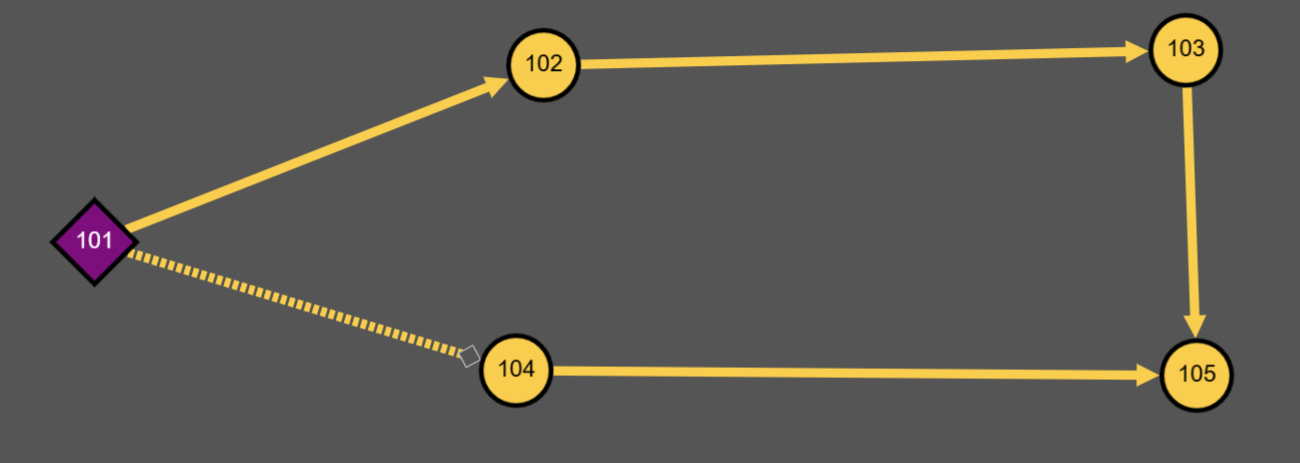

In [ ]:
print("\nDeactivate branch 203 and activate branch 205, then recompute feeder IDs")
grid.make_inactive(branch=grid.line.get(203))
grid.make_active(branch=grid.line.get(205))
grid.set_feeder_ids()

print("Nodes after recomputation")
for node_id, feeder_node, feeder_branch in zip(grid.node.id, grid.node.feeder_node_id, grid.node.feeder_branch_id):
    print(f"node {node_id}: feeder_node_id={feeder_node}, feeder_branch_id={feeder_branch}")

print("\nLines after recomputation")
for line_id, is_feeder, feeder_branch, feeder_node in zip(
    grid.line.id, grid.line.is_feeder, grid.line.feeder_branch_id, grid.line.feeder_node_id
):
    print(f"line {line_id}: is_feeder={is_feeder}, feeder_branch_id={feeder_branch}, feeder_node_id={feeder_node}")

## Best Practices

- Run `Grid.set_feeder_ids()` whenever you add, remove, or change the activation status of branches or substations so the feeder metadata matches the current topology.
- Use the `feeder_node_id` column to group or color nodes/branches by the feeding substation and to quickly find segments that lost their connection (they remain at `-2147483648`).
- Recompute feeder IDs before serializing or exporting a grid so fixtures and downstream tools can rely on the latest feeder tree without needing to rerun the calculation.

## Edge case
If a node lies in a connected path between two substation nodes, there is no unique `feeder_node_id` or `feeder_branch_id`. In this case one of the possible `feeder_node_id`/`feeder_branch_id` is picked and applied for all nodes in the path. 
So it is guarenteed that all nodes in the path have the same `feeder_node_id`/`feeder_branch_id`, eventhough there is no unique solution.

In [ ]:
grid = Grid.from_txt("S1 2 12", "2 3 23", "3 S4 34")
grid.set_feeder_ids()

print("Nodes:\n", grid.node)
print("\nLines:\n", grid.line)